In [1]:
# Import libraries.
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pysindy as ps 
from pysindy.differentiation import FiniteDifference
import scipy.integrate as integrate 
import matplotlib.gridspec as gridspec
import numexpr as ne
from numpy import cos, sin
from pysindy.utils import enzyme, yeast, pendulum_on_cart

In [2]:
# Julia language is required for SINDy-PI to be able to solve
# the differential algebraic equations (DAEs)
# Note that on my computer, at a terminal, I need to do:
# > julia  (enters the julia console)
# > import Pkg
# > Pkg.add("PyCall")
# > Pkg.add("DiffEqBase")
# > Pkg.add("DifferentialEquations")
# > exit()
# jupyter notebook (startup this notebook)

# Last thing to do (maybe specific to my installation)
from julia.api import Julia
jl = Julia(compiled_modules=False)
from diffeqpy import de

In [3]:
# Plot first three modes in 3D for ground truth and SINDy prediction
def make_3d_plots(x_test, x_test_pred, filename):
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(8,8))
    if filename == 'VonKarman':
        ind = -1
    else:
        ind = 2
    plt.plot(x_test[:, 0], x_test[:, 1], x_test[:, ind], 'r')
    plt.plot(x_test_pred[:, 0], x_test_pred[:, 1], x_test_pred[:, ind], 'k')
    ax = plt.gca()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_axis_off()
    plt.savefig(filename + '_3d.pdf')


# Plot the SINDy fits of X and Xdot against the ground truth
def make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, filename):
    fig = plt.figure(figsize=(30, 30))
    spec = gridspec.GridSpec(ncols=2, nrows=r, figure=fig, hspace=0.0, wspace=0.0)
    for i in range(r):
        plt.subplot(spec[i, 0]) #r, 2, 2 * i + 2)
        plt.plot(t, xdot_test[:, i], 'r')
        plt.plot(t, xdot_test_pred[:, i], 'k--')
        ax = plt.gca()
        ax.set_xticklabels([])
        #ax.set_yticklabels([])
        plt.subplot(spec[i, 1])
        plt.plot(t, x_test[:, i], 'r')
        plt.plot(t, x_test_pred[:, i], 'k--')
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    plt.savefig(filename + '_fits.pdf')
    

# Fix feature names
def fix_feature_names(feature_names, r):
    for i in range(len(feature_names)):
        if feature_names[i] == '':
            feature_names[i] = '1'
        for j in range(r):
            feature_names[i] = feature_names[i].replace("sin(x" + str(j) + ")", "sin(u[" + str(j) + "])*")  
            feature_names[i] = feature_names[i].replace("cos(x" + str(j) + ")", "cos(u[" + str(j) + "])*")
        for j in range(r):
            feature_names[i] = feature_names[i].replace("xdot" + str(j), "du[" + str(j) + "]*")  
            feature_names[i] = feature_names[i].replace("x" + str(j), "u[" + str(j) + "]*") 
        if feature_names[i][-1] == '*':
            feature_names[i] = feature_names[i][:-1]
        print(i, feature_names[i])
    return feature_names


# Function to build a symbolic DAE
# Extract the coefficients and build up a string to evaluate
def build_symbolic_DAE(sindy_opt, feature_names, r, coefs, coef_indices):
    full_string = ''
    for k in range(r):
        eval_string = ''
        for i in range(len(feature_names)):
            eval_string += 'coefs[' + str(i) + ', ' + str(k) + '] * eval(feature_names[' + str(i) + '])'
            if i != len(feature_names) - 1:
                eval_string += ' + '
            else:
                eval_string += ' - eval(feature_names[' + str(coef_indices[k]) + '])' # du[' + str(k) + ']'
        # Okay, now have the eval string for one of the ODEs and need to string together
        if k == 0 and r == 1:
            full_string = eval_string
        elif k == 0:
            full_string += '[' + eval_string + ', '
        elif k != 0 and k != r - 1:
            full_string += eval_string + ', '
        elif k != 0 and k == r - 1:
            full_string += eval_string + ']'
    return full_string


# Definition of the model error for choosing a model at the end
def model_error(xdot_test, Theta, full_coefficients):
    return np.linalg.norm(Theta - Theta @ full_coefficients, axis=0) / np.linalg.norm(Theta, axis=0) 


# Definition of the derivative prediction error for choosing a model at the end
def prediction_error(xdot_test, xdot_test_pred):
    return np.linalg.norm(xdot_test - xdot_test_pred, axis=0) / np.linalg.norm(xdot_test, axis=0)

In [4]:
# define parameters
r = 1
dt = 0.01
T = 5
t = np.arange(0, T + dt, dt)
x0_train = [0.55]
x_train = integrate.odeint(enzyme, x0_train, t)
x0_test = [0.05]
x_test = integrate.odeint(enzyme, x0_test, t)

# define hyperparameters
threshold = 1e-5

fd = FiniteDifference(drop_endpoints=False)
xdot_train = np.nan_to_num(fd._differentiate(x_train, t)) # * dt)
xdot_test = np.nan_to_num(fd._differentiate(x_test, t)) # * dt)

# Initialize custom SINDy library so that we can have xdot inside it. Using the library
# Found in Equation A1 in the SINDy-PI paper
x_library_functions = [lambda x:1, lambda x:x, lambda x, y:x * y, lambda x:x ** 2, 
                       lambda x, y, z:x * y * z, lambda x, y: x * y ** 2, lambda x: x ** 3,
                       lambda x, y, z, w: x * y * z * w, lambda x, y, z:x * y * z ** 2,
                       lambda x, y:x * y ** 3, lambda x:x ** 4]
xdot_library_functions = [lambda x:1, lambda x:x]
        
library_function_names = [lambda x:'', lambda x:x, lambda x, y: x + y, lambda x:x + x, 
                          lambda x, y, z:x + y + z, lambda x, y: x + y + y, lambda x: x + x + x,
                          lambda x, y, z, w: x + y + z + w, lambda x, y, z:x + y + z + z,
                          lambda x, y:x + y + y + y, lambda x:x + x + x + x,
                          lambda x:'', lambda x:x] 
sindy_library = ps.SINDyPILibrary(library_functions=x_library_functions, 
                                  xdot_library_functions=xdot_library_functions,
                                  t=t[1:-1],
                                  function_names=library_function_names,
                                  )

sindy_opt = ps.SINDyPIoptimizer(threshold=threshold, tol=1e-10, thresholder="l1", max_iter=20000)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t)

(499, 1)
Solver failed on model  4 , setting coefs to zeros


SINDy(differentiation_method=FiniteDifference(drop_endpoints=True),
      feature_library=<pysindy.feature_library.SINDyPI_library.SINDyPILibrary object at 0x7f45c3ec7a90>,
      feature_names=['x0'],
      optimizer=SINDyPIoptimizer(max_iter=20000, model_subset=range(0, 10),
                                 threshold=1e-05, tol=1e-10))

0 1
1 u[0]
2 u[0]*u[0]
3 u[0]*u[0]*u[0]
4 u[0]*u[0]*u[0]*u[0]
5 du[0]
6 u[0]*du[0]
7 u[0]*u[0]*du[0]
8 u[0]*u[0]*u[0]*du[0]
9 u[0]*u[0]*u[0]*u[0]*du[0]
 = 5.000 x0 + 1.667 xdot0 + 5.556 x0xdot0
x0 = 0.200  + 0.004 x0x0 + -0.334 xdot0 + -1.105 x0xdot0
x0x0 = 0.023  + 0.063 x0 + 0.589 x0x0x0 + -0.724 x0xdot0
x0x0x0 = -0.007  + 0.352 x0x0 + 0.743 x0x0x0x0 + 0.032 xdot0 + -0.101 x0x0xdot0
x0x0x0x0 = 0.000
xdot0 = 0.598  + -2.995 x0 + 0.014 x0x0 + -3.306 x0xdot0
x0xdot0 = 0.177  + -0.883 x0 + -0.013 x0x0 + -0.293 xdot0
x0x0xdot0 = 0.014  + -0.273 x0x0 + -0.368 x0x0x0 + -0.047 xdot0
x0x0x0xdot0 = 0.010 x0 + -0.157 x0x0x0 + -0.477 x0x0x0x0 + -0.007 xdot0
x0x0x0x0xdot0 = 0.001  + -0.519 x0x0x0x0 + 0.010 xdot0 + -0.082 x0xdot0


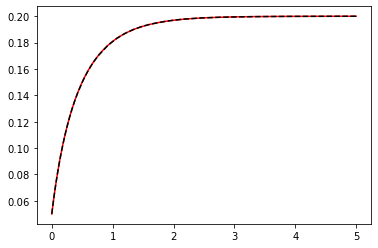

In [5]:
coef_indices = np.arange(1, r + 1)
coefs = np.transpose(sindy_opt.coef_)[:, coef_indices]
feature_names = model.get_feature_names()
feature_names = fix_feature_names(feature_names, r)
eval_string = build_symbolic_DAE(sindy_opt, feature_names, 1, coefs, coef_indices)
model.print()

# Define a SINDy differential algebraic equation (DAE)
def SINDy_model(du, u, p, t):
    resid = eval(eval_string)
    return resid

du0 = [-0.04]
tspan = (t[0], t[-1])
differential_vars = [True]
prob = de.DAEProblem(SINDy_model, du0, x0_test, tspan, differential_vars=differential_vars)
plt.plot(t, x_test, 'r')
sol = de.solve(prob)
plt.plot(sol.t, sol.u, 'k--')

0 1
1 u[0]
2 u[0]*u[0]
3 u[0]*u[0]*u[0]
4 u[0]*u[0]*u[0]*u[0]
5 du[0]
6 u[0]*du[0]
7 u[0]*u[0]*du[0]
8 u[0]*u[0]*u[0]*du[0]
9 u[0]*u[0]*u[0]*u[0]*du[0]
 = 5.000 x0 + 1.667 xdot0 + 5.556 x0xdot0
x0 = 0.200  + 0.004 x0x0 + -0.334 xdot0 + -1.105 x0xdot0
x0x0 = 0.023  + 0.063 x0 + 0.589 x0x0x0 + -0.724 x0xdot0
x0x0x0 = -0.007  + 0.352 x0x0 + 0.743 x0x0x0x0 + 0.032 xdot0 + -0.101 x0x0xdot0
x0x0x0x0 = 0.000
xdot0 = 0.598  + -2.995 x0 + 0.014 x0x0 + -3.306 x0xdot0
x0xdot0 = 0.177  + -0.883 x0 + -0.013 x0x0 + -0.293 xdot0
x0x0xdot0 = 0.014  + -0.273 x0x0 + -0.368 x0x0x0 + -0.047 xdot0
x0x0x0xdot0 = 0.010 x0 + -0.157 x0x0x0 + -0.477 x0x0x0x0 + -0.007 xdot0
x0x0x0x0xdot0 = 0.001  + -0.519 x0x0x0x0 + 0.010 xdot0 + -0.082 x0xdot0


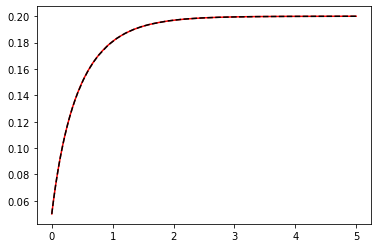

In [6]:
coef_indices = np.arange(5, r + 5)
coefs = np.transpose(sindy_opt.coef_)[:, coef_indices]
feature_names = model.get_feature_names()
feature_names = fix_feature_names(feature_names, r)
eval_string = build_symbolic_DAE(sindy_opt, feature_names, 1, coefs, coef_indices)
model.print()

prob = de.DAEProblem(SINDy_model, du0, x0_test, tspan, differential_vars=differential_vars)
plt.plot(t, x_test, 'r')
sol = de.solve(prob)
plt.plot(sol.t, sol.u, 'k--')

In [ ]:
# define parameters
r = 7
dt = 0.01
T = 2
t = np.arange(0, T + dt, dt)
# n_trajectories = 20

x0_train = 0.2 * np.ones(r)
x_train = integrate.odeint(yeast, x0_train, t)
# #x0_test = 0.2 * np.ones(r)
# #x_test = integrate.odeint(yeast, x0_test, t)
# x_train_multi = []
# xdot_train_multi = []
# t_train_multi = []
# for i in range(n_trajectories):
#     x0_train = np.random.rand(r)
#     x_train_multi.append(integrate.odeint(yeast, x0_train, t))
#     xdot_train_multi.append(np.nan_to_num(fd._differentiate(x_train_multi[i], t)))
#     t_train_multi.append(t[1:-1])
# print(np.shape(x_train_multi), np.shape(t_train_multi))
# define hyperparameters
threshold = 1e-2
#model_subset = range(1, r + 1)
model_subset = [43, 86, 129, 172, 215, 258, 301]



x_library_functions = [lambda x:1, lambda x:x, lambda x:x ** 2, lambda x, y:x * y,
                       lambda x: x ** 4]
xdot_library_functions = [lambda x:1, lambda x:x]
        
library_function_names = [lambda x:'', lambda x:x, lambda x:x + x, lambda x, y:x + y,
                          lambda x:x + x + x + x,
                          lambda x:'', lambda x:x] 

sindy_library = ps.SINDyPILibrary(library_functions=x_library_functions, 
                                  xdot_library_functions=xdot_library_functions,
                                  #t=np.ravel(np.asarray(t_train_multi)),
                                  t=t[1:-1],
                                  function_names=library_function_names,
                                  )

sindy_opt = ps.SINDyPIoptimizer(threshold=threshold, 
                                tol=1e-8, 
                                thresholder="l1",
                                max_iter=20000,
                                model_subset=model_subset)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
# normalize data
#x_train = x_train / np.mean(x_train, axis=0)
#x_test = x_test / np.mean(x_train, axis=0)
#model.fit(x_train_multi, t=dt, multiple_trajectories=True)
model.fit(x_train, t=t)
#print(model.get_feature_names())
#print(np.shape(model.get_feature_names()))
#print(np.shape(sindy_opt.Theta), np.shape(sindy_opt.coef_))


In [ ]:
model.print(precision=3)
model_names = np.asarray(model.get_feature_names())
#print(model_names)
for i in range(r):
    print(np.where(model_names == 'xdot' + str(i)))


In [ ]:
x_test = integrate.odeint(yeast, x0_train, t)
#x_test = x_test / np.mean(x_test, axis=0)
xdot_test = np.nan_to_num(fd._differentiate(x_test, t))
#xdot_test = model.differentiate(x_test, t=t)[1:-1, :]
xdot_test_pred = sindy_opt.Theta @ np.transpose(sindy_opt.coef_)
#xdot_test_pred = sindy_opt.Theta @ sindy_opt.coef_
make_fits(r, t[1:-1], xdot_train[1:-1, :], xdot_test_pred[:, model_subset], x_test[1:-1], x_test[1:-1], 'yeast')

In [ ]:
r = 7
coefs = np.transpose(sindy_opt.coef_)[:, model_subset]
feature_names = model.get_feature_names()
feature_names = fix_feature_names(feature_names, r)
eval_string = build_symbolic_DAE(sindy_opt, feature_names, r, coefs, model_subset)
print(eval_string, np.shape(coefs))

# Define a SINDy differential algebraic equation (DAE)
def SINDy_DAE(du, u, p, t):
    resid = eval(eval_string)
    print(resid)
    return resid


u0 = np.asarray(x0_train) #np.random.rand(r)  #[np.pi, 0.0, 0.0, 0.0]
du0 = np.random.rand(r)
tspan = (t[0], t[-1])
differential_vars = [True, True, True, True, True, True, True]
prob = de.DAEProblem(SINDy_DAE, du0, u0, tspan, differential_vars=differential_vars)
sol = de.solve(prob)
colors = ['r', 'b', 'g', 'k', 'c', 'm', 'y']
x_test = integrate.odeint(yeast, u0, t)
plt.figure(figsize=(20, 6))
for i in range(r):
    plt.subplot(1, r, i + 1)
    plt.plot(t, x_test[:, i], colors[i], label=str(i))
    plt.plot(sol.t, np.asarray(sol.u)[:, i], colors[i] + '--')
plt.legend()

In [11]:
# define parameters
r = 4
dt = 0.005
T = 50
t = np.arange(0, T + dt, dt)

x0_train = [0.3, 0, 1, 1]
x_train = integrate.odeint(pendulum_on_cart, x0_train, t, args=(1, 1, 1, 1, 9.81))
x0_test = [0.1, 0, 0.1, 2]
x_test = integrate.odeint(pendulum_on_cart, x0_test, t, args=(1, 1, 1, 1, 9.81))

# define hyperparameters
threshold = 1e1
# model_subset = [9, 10, 11, 12, 87, 88]
model_subset = [17, 34, 51, 68]


xdot_train = np.nan_to_num(fd._differentiate(x_train, t))
xdot_test = np.nan_to_num(fd._differentiate(x_test, t))

x_library_functions = [lambda x:1, lambda x:x, lambda x:sin(x),
                       lambda x: sin(x) * sin(x), lambda x: sin(x) * cos(x)]
xdot_library_functions = [lambda x:1, lambda x:x, lambda x:x ** 2]
        
library_function_names = [lambda x:'', lambda x:x, lambda x: 'sin(' + x + ')',
                          lambda x: 'sin(' + x + ')' + 'sin(' + x + ')', 
                          lambda x: 'sin(' + x + ')' + 'cos(' + x + ')',
                          lambda x:'', lambda x:x, lambda x: x + x] 

sindy_library = ps.SINDyPILibrary(library_functions=x_library_functions, 
                                  xdot_library_functions=xdot_library_functions,
                                  t=t[1:-1],
                                  function_names=library_function_names,
                                  )

thresholds = np.zeros((153, 153))
thresholds[model_subset[0:2], :] = 1e1
thresholds[model_subset[2:4], :] = 1e1
sindy_opt = ps.SINDyPIoptimizer(thresholds=thresholds, 
                                thresholder="weighted_l1",
                                #threshold=threshold,
                                #thresholder="l1",
                                tol=1e-5, 
                                max_iter=5000,
                                model_subset=model_subset)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
# normalize data
#x_train = x_train / np.mean(x_train, axis=0)
#x_test = x_test / np.mean(x_train, axis=0)
model.fit(x_train, t=t)
print(np.shape(model.get_feature_names()))
print(np.shape(sindy_opt.Theta), np.shape(sindy_opt.coef_))

(9999, 4)
(153,)
(9999, 153) (153, 153)


In [12]:
model.print(precision=2)
model_names = np.asarray(model.get_feature_names())
# for i in range(r):
#     print(np.where(model_names == 'xdot' + str(i)))

 = 0.00
x0 = 0.00
x1 = 0.00
x2 = 0.00
x3 = 0.00
sin(x0) = 0.00
sin(x1) = 0.00
sin(x2) = 0.00
sin(x3) = 0.00
sin(x0)sin(x0) = 0.00
sin(x1)sin(x1) = 0.00
sin(x2)sin(x2) = 0.00
sin(x3)sin(x3) = 0.00
sin(x0)cos(x0) = 0.00
sin(x1)cos(x1) = 0.00
sin(x2)cos(x2) = 0.00
sin(x3)cos(x3) = 0.00
xdot0 = 0.05  + 1.00 x2 + -0.30 sin(x0) + -0.29 sin(x0)sin(x0) + -0.33 sin(x0)cos(x0) + 0.01 x2xdot0 + 0.02 xdot2 + 0.07 sin(x0)xdot2 + 0.02 sin(x0)sin(x0)xdot2 + -0.10 sin(x0)cos(x0)xdot2 + -0.03 xdot3 + -0.20 sin(x0)xdot3 + -0.03 sin(x0)sin(x0)xdot3 + -0.02 sin(x0)cos(x0)xdot3 + -0.01 xdot0xdot0 + 0.03 sin(x0)xdot0xdot0 + 0.10 sin(x0)sin(x0)xdot0xdot0 + 0.02 sin(x0)cos(x0)xdot0xdot0
x0xdot0 = 0.00
x1xdot0 = 0.00
x2xdot0 = 0.00
x3xdot0 = 0.00
sin(x0)xdot0 = 0.00
sin(x1)xdot0 = 0.00
sin(x2)xdot0 = 0.00
sin(x3)xdot0 = 0.00
sin(x0)sin(x0)xdot0 = 0.00
sin(x1)sin(x1)xdot0 = 0.00
sin(x2)sin(x2)xdot0 = 0.00
sin(x3)sin(x3)xdot0 = 0.00
sin(x0)cos(x0)xdot0 = 0.00
sin(x1)cos(x1)xdot0 = 0.00
sin(x2)cos(x2)xdot0 = 0.00

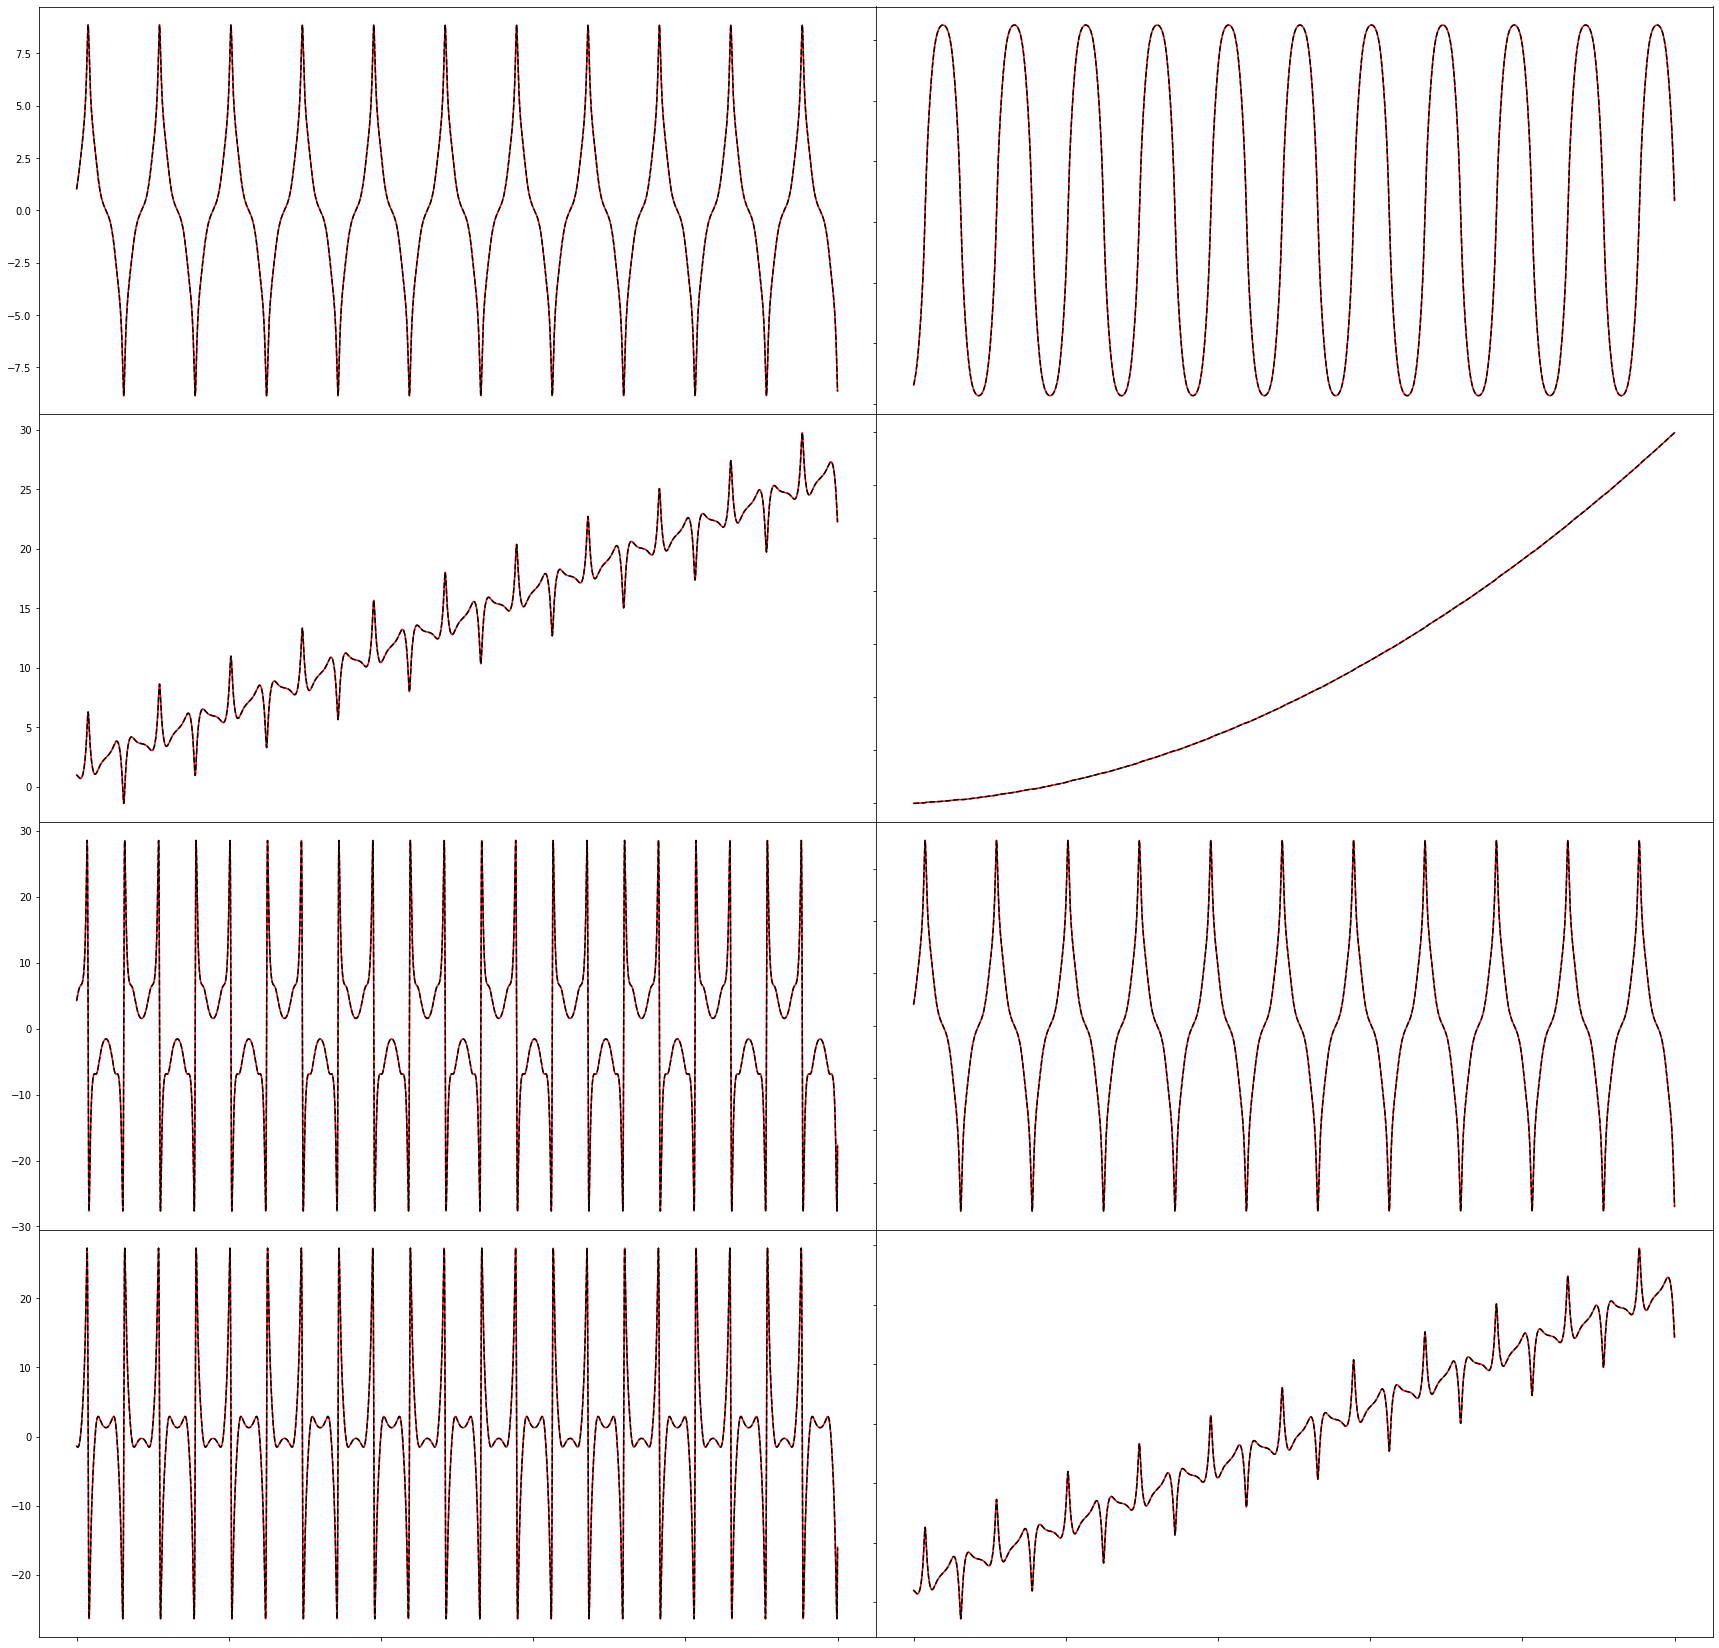

In [13]:
x_test = integrate.odeint(pendulum_on_cart, x0_train, t, args=(1, 1, 1, 1, 9.81))
#x_test = x_test / np.mean(x_test, axis=0)
xdot_train = np.nan_to_num(fd._differentiate(x_train, t))
xdot_test = np.nan_to_num(fd._differentiate(x_test, t))
#xdot_test = model.differentiate(x_test, t=t)[1:-1, :]
xdot_test_pred = sindy_opt.Theta @ np.transpose(sindy_opt.coef_)
make_fits(r, t[1:-1], xdot_train[1:-1], xdot_test_pred[:, model_subset], x_test[1:-1], x_test[1:-1], 'pendulum_on_cart')

0 1
1 u[0]
2 u[1]
3 u[2]
4 u[3]
5 sin(u[0])
6 sin(u[1])
7 sin(u[2])
8 sin(u[3])
9 sin(u[0])*sin(u[0])
10 sin(u[1])*sin(u[1])
11 sin(u[2])*sin(u[2])
12 sin(u[3])*sin(u[3])
13 sin(u[0])*cos(u[0])
14 sin(u[1])*cos(u[1])
15 sin(u[2])*cos(u[2])
16 sin(u[3])*cos(u[3])
17 du[0]
18 u[0]*du[0]
19 u[1]*du[0]
20 u[2]*du[0]
21 u[3]*du[0]
22 sin(u[0])*du[0]
23 sin(u[1])*du[0]
24 sin(u[2])*du[0]
25 sin(u[3])*du[0]
26 sin(u[0])*sin(u[0])*du[0]
27 sin(u[1])*sin(u[1])*du[0]
28 sin(u[2])*sin(u[2])*du[0]
29 sin(u[3])*sin(u[3])*du[0]
30 sin(u[0])*cos(u[0])*du[0]
31 sin(u[1])*cos(u[1])*du[0]
32 sin(u[2])*cos(u[2])*du[0]
33 sin(u[3])*cos(u[3])*du[0]
34 du[1]
35 u[0]*du[1]
36 u[1]*du[1]
37 u[2]*du[1]
38 u[3]*du[1]
39 sin(u[0])*du[1]
40 sin(u[1])*du[1]
41 sin(u[2])*du[1]
42 sin(u[3])*du[1]
43 sin(u[0])*sin(u[0])*du[1]
44 sin(u[1])*sin(u[1])*du[1]
45 sin(u[2])*sin(u[2])*du[1]
46 sin(u[3])*sin(u[3])*du[1]
47 sin(u[0])*cos(u[0])*du[1]
48 sin(u[1])*cos(u[1])*du[1]
49 sin(u[2])*cos(u[2])*du[1]
50 sin(u[3])*cos(u[3

[-0.013840326859424046, -0.03226031022706333, 0.7075767665578547, 0.17314537027177573]
[-0.019014731258403472, -0.03486309345051697, 0.6682757014614393, 0.14974613420393298]
[-0.023397501090019257, -0.03698361854985721, 0.6364784798126917, 0.13122545154052567]
[-0.027096793266630614, -0.03868759716456349, 0.6112378759964683, 0.11695670104763486]
[-0.030205932353692733, -0.040031669155955574, 0.5917281088783408, 0.10639539469338316]
[-0.032805462684503794, -0.04106466444576451, 0.5772304673732258, 0.0990689755478558]
[-0.03496491078048081, -0.0418286850667674, 0.5671203605050262, 0.09456776651297229]
[0.07655878559191642, 0.3251885433149243, -0.41461150393447666, -0.5583601185703031]
[29440.709615837848, 27251.283894197095, -5363857.278396672, -2563798.8493187623]
[0.059627696351626014, -4.517728277973416, 0.8377086454824368, -0.04768845900579988]
[-100778.1945724016, -129625.17501949782, -1435518.2853475583, -1312217.739365268]
[92884.07585184161, 56266.762056146865, -2411253.380622844

No handles with labels found to put in legend.


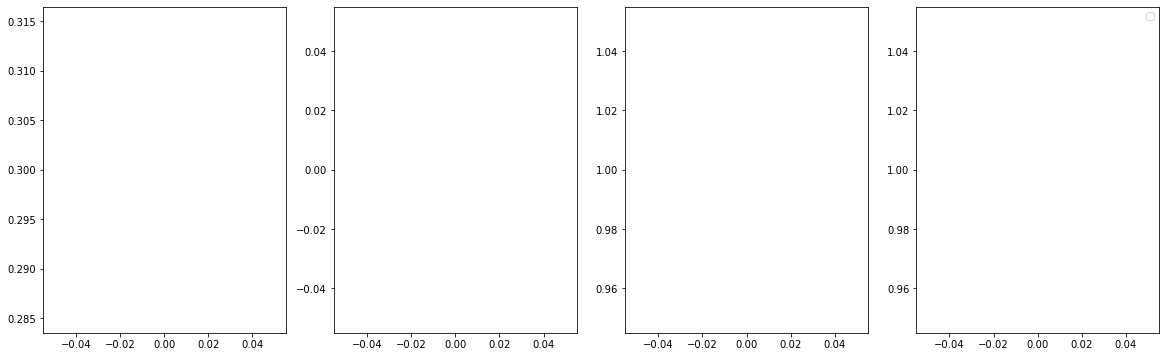

In [14]:
r = 4
coefs = np.transpose(sindy_opt.coef_)[:, model_subset]
feature_names = model.get_feature_names()
feature_names = fix_feature_names(feature_names, r)
eval_string = build_symbolic_DAE(sindy_opt, feature_names, r, coefs, model_subset)
print(eval_string, np.shape(coefs))

# Define a SINDy differential algebraic equation (DAE)
def SINDy_DAE(du, u, p, t):
    resid = eval(eval_string)
    print(resid)
    return resid


u0 = np.asarray(x0_train) #np.random.rand(r)  #[np.pi, 0.0, 0.0, 0.0]
du0 = np.random.rand(r)
tspan = (t[0], t[-1])
differential_vars = [True, True, True, True]
prob = de.DAEProblem(SINDy_DAE, du0, u0, tspan, differential_vars=differential_vars)
sol = de.solve(prob)
colors = ['r', 'b', 'g', 'k']
x_test = integrate.odeint(pendulum_on_cart, u0 , t, args=(1, 1, 1, 1, 9.81))
plt.figure(figsize=(20, 6))
for i in range(r):
    plt.subplot(1, r, i + 1)
    #plt.plot(t, x_test[:, i], colors[i], label=str(i))
    plt.plot(sol.t, np.asarray(sol.u)[:, i], colors[i] + '--')
plt.legend()